# Pipeline Overview
https://learnopencv.com/monocular-slam-in-python/#aioseo-what-is-slam

In [54]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

## Feature Extraction


Keypoints: Contain 2D coordinates of the feature points, but also other information like scale, orientation, and size of the feature point.

Descriptors: Contain information about the feature point that can be used to uniquely identify it. (vector that numericly describes pixels around the keypoint)

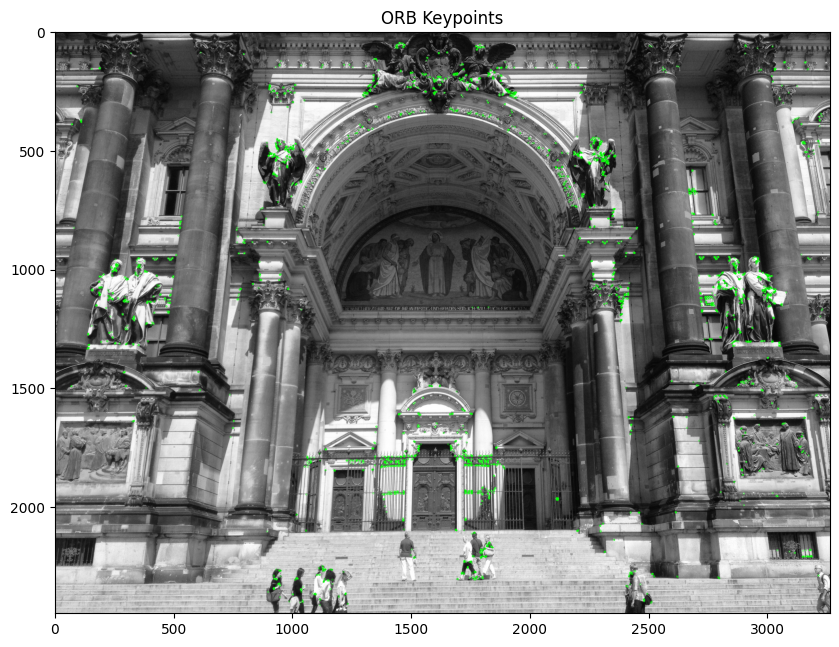

In [55]:
# Load the image
image = cv2.imread('./01.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize the ORB detector
orb = cv2.ORB_create(nfeatures=5000)

# Detect keypoints and compute descriptors
keypoints, descriptors = orb.detectAndCompute(image, None)

# Draw the keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)

# Display the image with keypoints
plt.figure(figsize=(10, 10))
plt.imshow(image_with_keypoints, cmap='gray')
plt.title('ORB Keypoints')
plt.show()

## Feature Matching

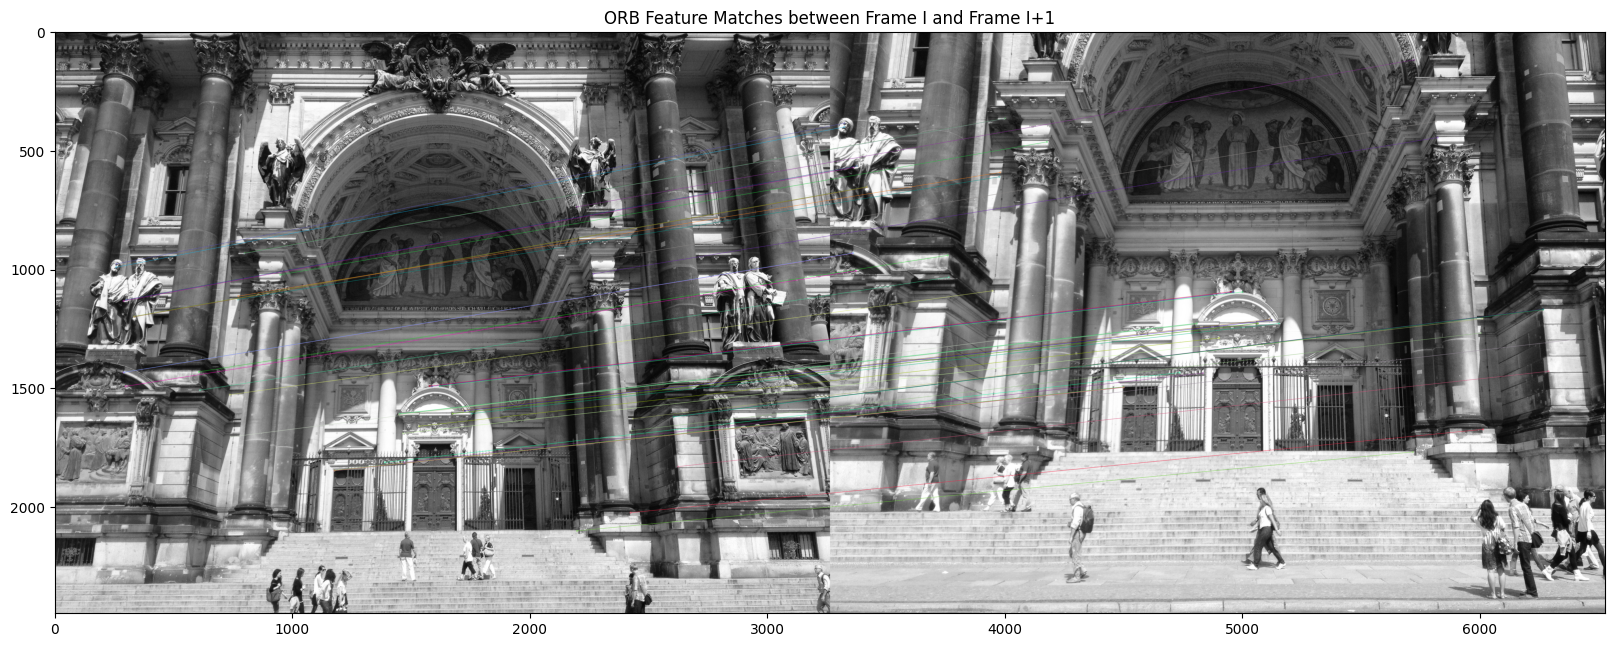

Matched points in frame I:
[[2433.     1630.    ]
 [1587.     1494.    ]
 [ 948.0502 1025.1881]
 ...
 [1853.7987 1922.2274]
 [1389.     1999.    ]
 [2829.6    1071.36  ]]
Matched points in frame I+1:
[[2748.      1209.6001 ]
 [1699.2001  1098.     ]
 [ 913.71136  465.81363]
 ...
 [3174.0002   582.     ]
 [3085.      2100.     ]
 [2727.1995  1201.8589 ]]


In [56]:
# Load the initial image (frame I)
image1 = cv2.imread('./01.jpg', cv2.IMREAD_GRAYSCALE)

# Load the subsequent image (frame I+1)
image2 = cv2.imread('./02.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize the ORB detector
orb = cv2.ORB_create(nfeatures=5000)

# Detect keypoints and compute descriptors for the first image
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)

# Detect keypoints and compute descriptors for the second image
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

# Initialize the BFMatcher with default params
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the top N matches (for example, the top 50 matches)
top_matches = matches[:50]
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, top_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the image with matches
plt.figure(figsize=(20, 15))
plt.imshow(matched_image)
plt.title('ORB Feature Matches between Frame I and Frame I+1')
plt.show()

# Optionally, extract the matched points
matched_points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
matched_points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# Print the coordinates of the matched points
print("Matched points in frame I:")
print(matched_points1)
print("Matched points in frame I+1:")
print(matched_points2)


## Pose Estimation

In [57]:
# Camera intrinsic parameters (can be obtained from camera calibration with opencv)
K = np.array([[3177.000, 0, 1632.000],
            [0, 3177.00, 1224.00],
            [0, 0, 1]])


# Optionally, extract the matched points
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# Compute the Fundamental matrix using RANSAC
F, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Select inlier points
pts1_inliers = pts1[inliers.ravel() == 1]
pts2_inliers = pts2[inliers.ravel() == 1]

# estimate essential matrix
E = K.T @ F @ K

_, R, t, mask = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

print("Rotation matrix R:")
print(R)
print("Translation vector t:")
print(t)

Rotation matrix R:
[[ 9.99490896e-01  3.05264927e-03  3.17589229e-02]
 [-4.37936585e-04  9.96631145e-01 -8.20132257e-02]
 [-3.19022893e-02  8.19575640e-02  9.96125093e-01]]
Translation vector t:
[[ 0.02095784]
 [-0.28771727]
 [-0.95748605]]


## Triangulation for 3D Mapping:

In [58]:
def add_ones(x):
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)

T = np.eye(4) 
T[0:3,0:3] = R
T[0:3,3] = t.T
Kinv = np.linalg.inv(K)
pose1 = np.eye(4)
pose2 = np.eye(4) @ T

# Optionally, extract the matched points
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])



ret = np.zeros((pts1.shape[0], 4))
pose1 = np.linalg.inv(pose1)
pose2 = np.linalg.inv(pose2)
for i, p in enumerate(zip(add_ones(pts1), 
                          add_ones(pts2))):
    A = np.zeros((4, 4))
    A[0] = p[0][0] * pose1[2] - pose1[0]
    A[1] = p[0][1] * pose1[2] - pose1[1]
    A[2] = p[1][0] * pose2[2] - pose2[0]
    A[3] = p[1][1] * pose2[2] - pose2[1]
    _, _, vt = np.linalg.svd(A)
    ret[i] = vt[3]

ret /= ret[:, 3:]
good_pts4d =   (np.abs(ret[:, 3]) > 0.005) & (ret[:, 2] > 0)

mapp_pts = [p for i, p in enumerate(ret) if good_pts4d[i]]


Save Map in a File 

/Users/niklasprobst/Desktop/Mapping/.venv/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


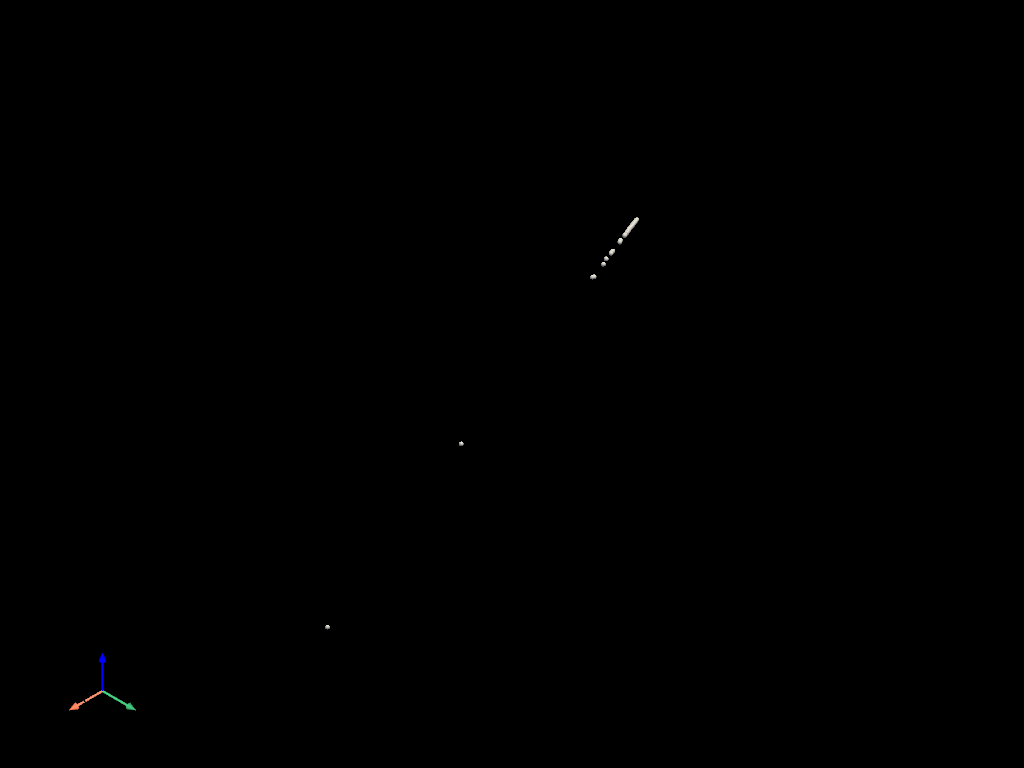

In [62]:
import pyvista as pv

# Create a PyVista plotter object
plotter = pv.Plotter()

# Convert the mapped points to a PyVista PolyData object
points = np.array(mapp_pts)[:, :3]  # Extract only the x, y, z coordinates
point_cloud = pv.PolyData(points)

# Add the point cloud to the plotter
plotter.add_mesh(point_cloud, color='white', point_size=5, render_points_as_spheres=True)

# Set the background color
plotter.set_background('black')

# Add axes
plotter.add_axes()

# Show the plot
plotter.show()